In [337]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [271]:
sotrudnik = pd.read_csv("C:/Users/Григорий/Сотрудники.csv",sep=";",encoding="utf-8")

In [272]:
gorod = pd.read_csv("C:/Users/Григорий/Города.csv",sep=";",encoding="utf-8")

# 1. Предобработка таблицы:
1.1. В таблице есть ошибки данных (некорректный для поля тип данных, дубликат и пр.), укажите, как их обнаружили, и что предприняли для их устранения

1.2. Часть данных по некоторым должностям была утеряна, но известно, что ID имеет уникальную должность и локацию, и не меняется из периода в период, восстановите недостающие данные

1.3. Вытянуть строки с новыми штатными единицами, на которые еще не распределены должности и сотрудники. В графах Табельного номера и Должности проставить признак «Резерв»;


In [273]:
gorod.dtypes

Федеральный округ    object
Регион               object
Город                object
dtype: object

In [274]:
sotrudnik.dtypes


Период               int64
ID должности        object
Табельный номер    float64
Город               object
Должность           object
ФИО                 object
dtype: object

In [275]:
sotrudnik['Период'] = pd.to_datetime(sotrudnik['Период'], unit='D', origin='1899-12-30')

sotrudnik['ID должности'] = sotrudnik['ID должности'].astype(str)

# Извлекаем только числа из 'ID должности'
sotrudnik['ID должности'] = sotrudnik['ID должности'].str.extract(r'(\d+)', expand=False)

sotrudnik['ID должности'] = sotrudnik['ID должности'].astype('Int64')

In [276]:
sotrudnik['ID должности'].isnull().sum()

0

In [277]:
sotrudnik = sotrudnik.dropna(subset=['ID должности'])

In [278]:
sotrudnik = sotrudnik.drop_duplicates(subset=['Период', 'ID должности'], keep='first')

In [279]:
sotrudnik['Табельный номер'] = sotrudnik['Табельный номер'].astype('Int64')

In [280]:
  sotrudnik.duplicated().sum()

0

In [281]:
gorod.duplicated().sum()

0

In [282]:
gorod = gorod.dropna(subset=['Федеральный округ'])
gorod = gorod.dropna(subset=['Регион'])
gorod = gorod.drop_duplicates(subset=['Город'])

In [283]:
sotrudnik.isnull().sum()

Период               0
ID должности         0
Табельный номер    118
Город              121
Должность          145
ФИО                118
dtype: int64

In [284]:
sotrudnik.dtypes


Период             datetime64[ns]
ID должности                Int64
Табельный номер             Int64
Город                      object
Должность                  object
ФИО                        object
dtype: object

In [285]:
gorod.isnull().sum()

Федеральный округ    0
Регион               0
Город                0
dtype: int64

# 1.2 Восстановили данные 
Для восстановления данных сортируем по id должности и период чтобы внутри каждой должности периоды шли попорядку.

In [286]:
sotrudnik = sotrudnik.sort_values(by=['ID должности', 'Период'])
sotrudnik['Должность'] = sotrudnik.groupby('ID должности')['Должность'].ffill().bfill()
sotrudnik['Город'] = sotrudnik.groupby('ID должности')['Город'].ffill().bfill()

In [287]:
sotrudnik[sotrudnik['ID должности'] == 2000]

,Период,ID должности,Табельный номер,Город,Должность,ФИО
4996,2023-05-01,2000,<NA>,NaN,NaN,NaN


In [288]:
sotrudnik[sotrudnik['ID должности'] == 1099]

,Период,ID должности,Табельный номер,Город,Должность,ФИО
99,2023-01-01,1099,<NA>,Грязи,начальник отдела,NaN
1098,2023-02-01,1099,<NA>,Грязи,начальник отдела,NaN
2097,2023-03-01,1099,<NA>,Грязи,начальник отдела,NaN
3096,2023-04-01,1099,<NA>,Грязи,начальник отдела,NaN
4095,2023-05-01,1099,2300,Грязи,начальник отдела,Корнеев Б.


In [289]:
sotrudnik.isnull().sum()

Период               0
ID должности         0
Табельный номер    118
Город                6
Должность            6
ФИО                118
dtype: int64

In [290]:
sotrudnik

,Период,ID должности,Табельный номер,Город,Должность,ФИО
0,2023-01-01,1000,2201,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.
999,2023-02-01,1000,2201,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.
1998,2023-03-01,1000,2201,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.
2997,2023-04-01,1000,2201,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.
3996,2023-05-01,1000,2201,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.
...,...,...,...,...,...,...
4996,2023-05-01,2000,<NA>,NaN,NaN,NaN
4997,2023-05-01,2001,<NA>,NaN,NaN,NaN
4998,2023-05-01,2002,<NA>,NaN,NaN,NaN
4999,2023-05-01,2003,<NA>,NaN,NaN,NaN


# 1.3 Вытянуть строки с новыми штатными единицами, на которые еще не распределены должности и сотрудники. В графах Табельного номера и Должности проставить признак «Резерв»;
Резерв должен быть на тех строках, на которых табельный номер и сама должность пустые, так как до этого мы востановили известные нам должности по их id, но не воставноили табельные номера(потому что они нам неизвестны), поэтому нужно заполнять не все должности с пустыми табельными номерами, а только те у которых не удалось воставноить должность 

In [291]:
sotrudnik.shape

(5000, 6)

In [292]:
sotrudnik.head()

,Период,ID должности,Табельный номер,Город,Должность,ФИО
0,2023-01-01,1000,2201,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.
999,2023-02-01,1000,2201,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.
1998,2023-03-01,1000,2201,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.
2997,2023-04-01,1000,2201,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.
3996,2023-05-01,1000,2201,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.


In [293]:

sotrudnik['Табельный номер'] = sotrudnik['Табельный номер'].astype('object')
pusto = (sotrudnik['Табельный номер'].isna() & sotrudnik['Должность'].isna())

# Присваиваем 'Резерв' сразу в оба столбца
sotrudnik.loc[pusto, ['Табельный номер', 'Должность']] = 'Резерв'

In [294]:
sotrudnik.query('Должность == "Резерв"')

,Период,ID должности,Табельный номер,Город,Должность,ФИО
4995,2023-05-01,1999,Резерв,NaN,Резерв,NaN
4996,2023-05-01,2000,Резерв,NaN,Резерв,NaN
4997,2023-05-01,2001,Резерв,NaN,Резерв,NaN
4998,2023-05-01,2002,Резерв,NaN,Резерв,NaN
4999,2023-05-01,2003,Резерв,NaN,Резерв,NaN
5000,2023-05-01,2004,Резерв,NaN,Резерв,NaN


# 2 Построить сводную таблицу с разбивкой по месяцам со следующими показателями:

2.1. Количество действующих сотрудников (должностей);

2.2. Количество свободных должностей (подсказка: табельный номер пустой);

2.3. Доля свободных должностей от итого должностей;


In [295]:
sotrudnik['Месяц'] = sotrudnik['Период'].dt.to_period('M')

# 2.1. Количество занятых должностей (где табельный номер заполнен)
active_mask = (sotrudnik['Табельный номер'].notna()) & (sotrudnik['Табельный номер'] != '')
active_count = sotrudnik[active_mask].groupby('Месяц')['ID должности'].count()

# 2.2. Количество свободных должностей (где табельный номер пустой)
free_mask = (sotrudnik['Табельный номер'].isna()) | (sotrudnik['Табельный номер'] == '')
free_count = sotrudnik[free_mask].groupby('Месяц')['ID должности'].count()

# 2.3. Всего должностей
total_count = sotrudnik.groupby('Месяц')['ID должности'].count()

# 2.4. Доля свободных должностей
share_free = (free_count / total_count).fillna(0)

# Собираем всё в одну таблицу
pivot = pd.DataFrame({
    'Занятые должности': active_count,
    'Свободные должности': free_count,
    'Всего должностей': total_count,
    'Доля свободных': share_free
}).fillna(0).reset_index()

pivot

,Месяц,Занятые должности,Свободные должности,Всего должностей,Доля свободных
0,2023-01,986,13,999,0.013013
1,2023-02,975,24,999,0.024024
2,2023-03,974,24,998,0.024048
3,2023-04,970,29,999,0.029029
4,2023-05,983,22,1005,0.021891


# 3. Работа по дополнению предобработанной таблицы, добавьте следующие показатели:
3.1. Федеральные округа и Регионы;

3.2. Количество месяцев поиска сотрудника по должности накопительно по каждому месяцу (н-р должность "директор" не заполнена в январе до марта включительно, а в апреле заполнена, результат получится следующим: январь - 1, февраль - 2, март - 3). Задание повышенной сложности, если не получится реализовать, то напишите ваши идеи, как бы это могло быть реализовано. 


In [296]:
sotrudnik = sotrudnik.merge(gorod[['Город', 'Регион', 'Федеральный округ']], on='Город', how='left')

Для пункта 3.2 нужно написать функцию, сначала нужно найти что должность свободна, если должность свободна значит поле Табельный номер будет пустые, если поле свободно добавляем +1 и выводим месяц, если находит Табельный номер значит ищем следующую должность с пустым ТН


In [297]:
def count_search_months(fio_series):
    result = []
    count = 0
    for fio in fio_series:
        if pd.isnull(fio) or str(fio).strip() == '':
            count += 1
        else:
            count = 0
        result.append(count)
    return result

# Сортируем по ID должности и периоду (чтобы считать по времени)
sotrudnik = sotrudnik.sort_values(['ID должности', 'Период'])

# Применяем функцию к каждой должности
sotrudnik['Месяцев_поиска'] = (
    sotrudnik.groupby('ID должности')['Табельный номер']
    .transform(count_search_months)
)

In [317]:
sotrudnik.query('Месяцев_поиска == 3')

,Период,ID должности,Табельный номер,Город,Должность,ФИО,Месяц,Регион,Федеральный округ,Месяцев_поиска
352,2023-03-01,1070,<NA>,Рузаевка,менеджер,NaN,2023-03,Респ. Мордовия,ПФО,3
497,2023-03-01,1099,<NA>,Грязи,начальник отдела,NaN,2023-03,Липецкая обл.,ЦФО,3
522,2023-03-01,1104,<NA>,Бор,младший специалист,NaN,2023-03,Нижегородская обл.,ПФО,3
592,2023-03-01,1118,<NA>,Полевской,управляющий директор,NaN,2023-03,Свердловская обл.,УФО,3
1232,2023-03-01,1246,<NA>,Чебаркуль,главный менеджер по привлечению корпоративных ...,NaN,2023-03,Челябинская обл.,УФО,3
1402,2023-03-01,1280,<NA>,Алакуртти,заместитель управляющего,NaN,2023-03,Мурманская обл.,СЗФО,3
1497,2023-03-01,1299,<NA>,Забайкальск,старший кассир,NaN,2023-03,Забайкальский край,ДФО,3
1513,2023-04-01,1302,<NA>,Сосновый Бор,эксперт,NaN,2023-04,Ленинградская обл.,СЗФО,3
1653,2023-04-01,1330,<NA>,Когалым,главный кредитный аналитик,NaN,2023-04,Ханты-Мансийский Автономный округ - Югра,УФО,3
1838,2023-04-01,1367,<NA>,Новый Уренгой,главный менеджер по привлечению корпоративных ...,NaN,2023-04,Ямало-Ненецкий АО,УФО,3


# 4. Ответьте на следующие вопросы, построив сводные таблицы исходя из дополненных данных пункта 3;
4.1. В каких городах наблюдается нехватка кадров на последний месяц? Отсортируйте по убыванию;

4.2. В каком регионе работает наибольшее количество сотрудников на последний месяц? Отсортируйте по убыванию;


4.3. Какие должности подвержены наибольшей текучести (подсказка: расчет из п.2.3)? Выведите наименование должности и коэффициенты текучести по месяцам, отразите первыми те должности, по которым наблюдалась наибольшая текучесть.


In [315]:
last_month = sotrudnik['Период'].max()

# Фильтруем строки за последний месяц, где должность существует и свободна
lack_mask = (
    (sotrudnik['Период'] == last_month) &
    ((sotrudnik['Табельный номер'].isnull()) | (sotrudnik['Табельный номер'].astype(str).str.strip() == '')) &
    (sotrudnik['Должность'].notnull()) & (sotrudnik['Должность'] != 'Резерв') &
    (sotrudnik['Город'].notnull()) & (sotrudnik['Город'] != 'Резерв')
)

# Считаем количество свободных должностей по городам
lack_by_city = (
    sotrudnik[lack_mask]
    .groupby('Город', as_index=False)
    .agg({'ID должности': 'count'})
    .sort_values('ID должности', ascending=False)
    .rename(columns={'ID должности': 'Свободных должностей'})
)

lack_by_city

,Город,Свободных должностей
2,Биробиджан,2
4,Городец,2
0,Анжеро-Судженск,1
11,Лобня,1
18,Сосновый Бор,1
17,Советский,1
16,Новый Уренгой,1
15,Нововоронеж,1
14,Нижний Новгород,1
13,Миасс,1


In [300]:
last_month = sotrudnik['Период'].max()

# Фильтруем строки за последний месяц, где ФИО не пустое (вакансия)
active_mask = (sotrudnik['Период'] == last_month) & (sotrudnik['ФИО'].notnull()) & (sotrudnik['ФИО'].astype(str).str.strip() != '')

# Считаем количество должностей по городам
active_by_city = (
    sotrudnik[active_mask]
    .groupby('Регион',as_index = False)
    .agg({'Период':'count'})
    .sort_values('Период', ascending=False)
    .rename(columns={'Период':'Работающих сотрудников'})
)

active_by_city

,Регион,Работающих сотрудников
24,Московская обл.,56
54,Свердловская обл.,50
60,Ханты-Мансийский Автономный округ - Югра,36
27,Нижегородская обл.,34
25,Мурманская обл.,33
...,...,...
6,Вологодская обл.,2
26,Ненецкий АО,2
23,Магаданская обл.,2
40,Респ. Кабардино-Балкарская,2


In [322]:
# Группируем по месяцам и должностям
turnover = sotrudnik.groupby(['Период', 'Должность']).agg({
    'Табельный номер': [
        ('Действующие', lambda x: ((x.notnull()) & (x != '')).sum()),
        ('Свободные', lambda x: ((x.isnull()) | (x == '')).sum()),
        ('Всего', 'count')
    ]
}).reset_index()

# Считаем коэффициент текучести в процентах
turnover['Коэффициент текучести'] = (turnover[('Табельный номер', 'Свободные')] / turnover[('Табельный номер', 'Всего')] * 100).round(2)

# Сортируем по убыванию коэффициента текучести
turnover = turnover.sort_values('Коэффициент текучести', ascending=False)

turnover.head(40)

Период                                          Должность  \
                                                                    
105 2023-04-01                    управляющий операционным офисом   
133 2023-05-01                    управляющий операционным офисом   
83  2023-04-01                         главный кредитный аналитик   
56  2023-03-01                         главный кредитный аналитик   
111 2023-05-01                         главный кредитный аналитик   
91  2023-04-01            директор по работе с крупными клиентами   
134 2023-05-01                                            эксперт   
79  2023-03-01                                            эксперт   
106 2023-04-01                                            эксперт   
119 2023-05-01            директор по работе с крупными клиентами   
23  2023-01-01            управляющий директор - начальник отдела   
50  2023-02-01            управляющий директор - начальник отдела   
100 2023-04-01                                руководитель группы   
73  2023-03-01                                руководитель группы   
46  2023-02-01                                руководитель группы   
128 2023-05-01                                руководитель группы   
51  2023-02-01                    управляющий операционным офисом   
78  2023-03-01                    управляющий операционным офисом   
29  2023-02-01                         главный кредитный аналитик   
58  2023-03-01  главный менеджер по привлечению корпоративных ...   
85  2023-04-01  главный менеджер по привлечению корпоративных ...   
31  2023-02-01  главный менеджер по привлечению корпоративных ...   
74  2023-03-01                                     старший кассир   
101 2023-04-01                                     старший кассир   
129 2023-05-01                                     старший кассир   
47  2023-02-01                                     старший кассир   
68  2023-03-01                                клиентский менеджер   
123 2023-05-01                                клиентский менеджер   
95  2023-04-01                                клиентский менеджер   
122 2023-05-01       заместитель управляющего операционным офисом   
70  2023-03-01                                 младший специалист   
97  2023-04-01                                 младший специалист   
52  2023-02-01                                            эксперт   
117 2023-05-01                                 главный специалист   
43  2023-02-01                                 младший специалист   
35  2023-02-01                                 главный специалист   
62  2023-03-01                                 главный специалист   
89  2023-04-01                                 главный специалист   
16  2023-01-01                                 младший специалист   
93  2023-04-01                           заместитель управляющего   

    Табельный номер                 Коэффициент текучести  
        Действующие Свободные Всего                        
105              35         4    35                 11.43  
133              36         3    36                  8.33  
83               37         3    37                  8.11  
56               37         3    37                  8.11  
111              37         3    37                  8.11  
91               27         2    27                  7.41  
134              27         2    27                  7.41  
79               27         2    27                  7.41  
106              27         2    27                  7.41  
119              27         2    27                  7.41  
23               43         3    43                  6.98  
50               43         3    43                  6.98  
100              34         2    34                  5.88  
73               34         2    34                  5.88  
46               34         2    34                  5.88  
128              34         2    34                  5.88  
51               37         2

# 5. Визуализация (тип диаграммы и библиотека на ваше усмотрение);
5.1. Количество действующих сотрудников по Федеральным округам;

5.2. Количество свободных должностей по регионам.


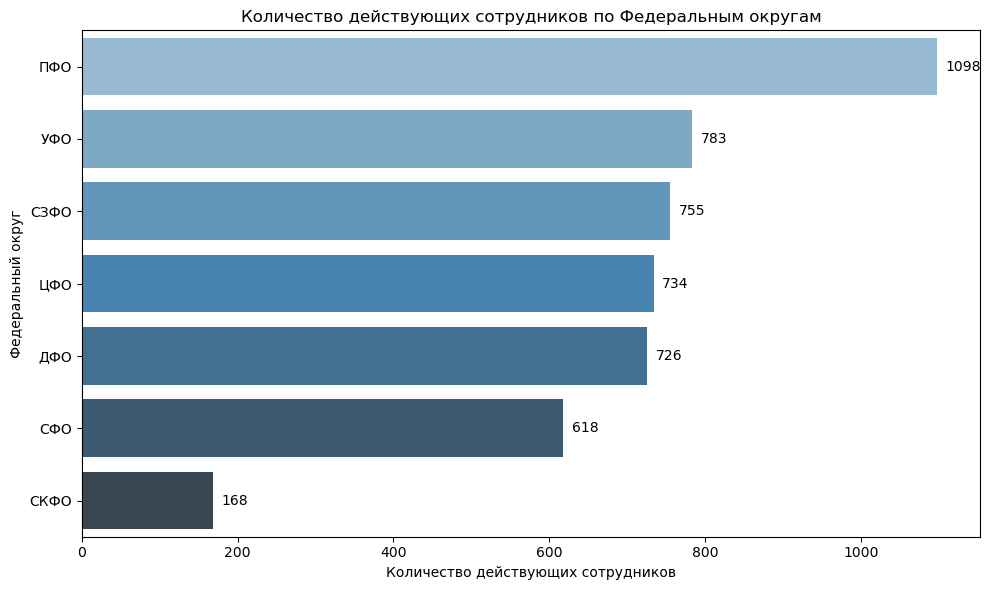

In [348]:


# Фильтр: действующие сотрудники (табельный номер заполнен)
active_mask = (sotrudnik['Табельный номер'].notna()) & (sotrudnik['Табельный номер'] != '')

# Группировка по Федеральному округу
active_by_okrug = (
    sotrudnik[active_mask]
    .groupby('Федеральный округ')['ID должности']
    .count()
    .sort_values(ascending=False)
    .reset_index(name='Действующих сотрудников')
)

# Визуализация
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=active_by_okrug,
    x='Действующих сотрудников',
    y='Федеральный округ',
    hue='Федеральный округ',
    palette='Blues_d',
    legend=False
)
plt.title('Количество действующих сотрудников по Федеральным округам')
plt.xlabel('Количество действующих сотрудников')
plt.ylabel('Федеральный округ')
plt.tight_layout()

for i, (value, label) in enumerate(zip(active_by_okrug['Действующих сотрудников'], active_by_okrug['Федеральный округ'])):
    ax.text(
        value + max(active_by_okrug['Действующих сотрудников']) * 0.01,  # немного смещаем вправо
        i,  # позиция по y
        str(value),
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

plt.show()

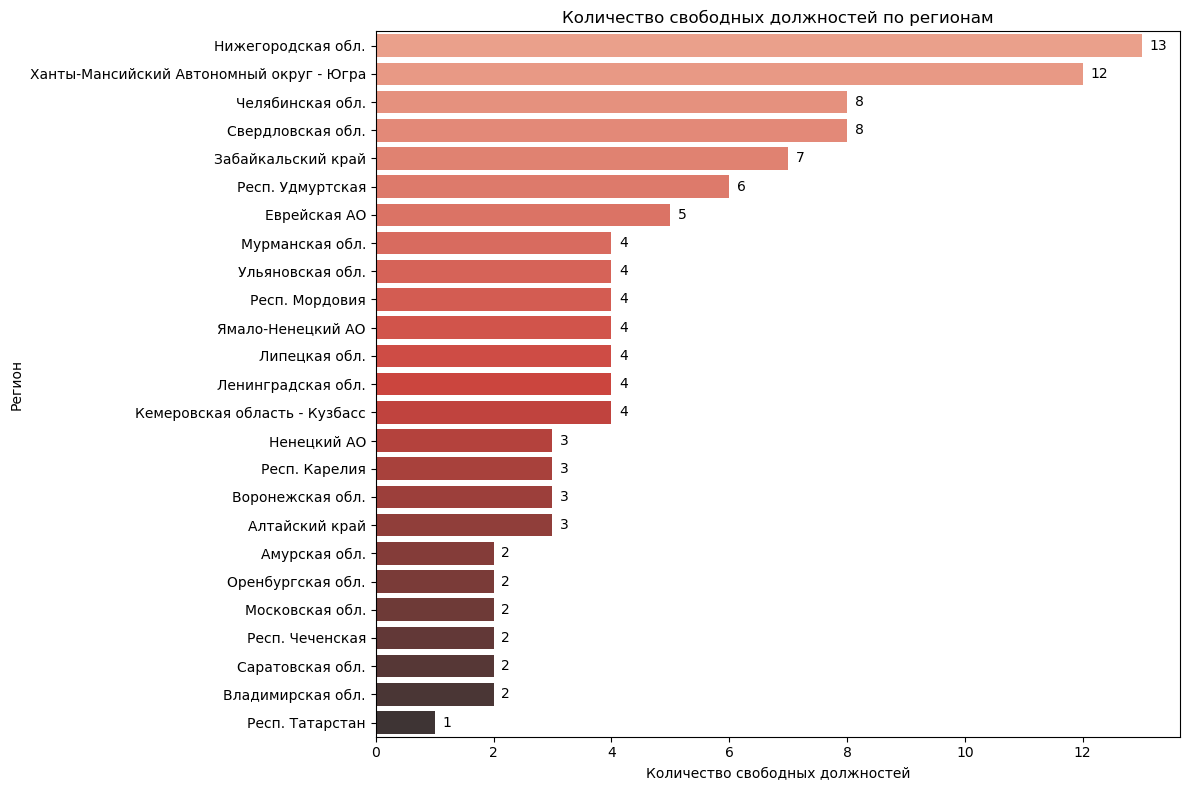

In [352]:
# Фильтр: свободные должности (табельный номер пустой)
free_mask = (sotrudnik['Табельный номер'].isna()) | (sotrudnik['Табельный номер'] == '')

# Группировка по региону
free_by_region = (
    sotrudnik[free_mask]
    .groupby('Регион')['ID должности']
    .count()
    .sort_values(ascending=False)
    .reset_index(name='Свободных должностей')
)

# Визуализация
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=free_by_region,
    x='Свободных должностей',
    y='Регион',
    hue='Регион',
    palette='Reds_d',
    legend=False            
)
plt.title('Количество свободных должностей по регионам')
plt.xlabel('Количество свободных должностей')
plt.ylabel('Регион')
plt.tight_layout()

# Добавляем подписи на каждом столбце
for a, (value, label) in enumerate(zip(free_by_region['Свободных должностей'], free_by_region['Регион'])):
    ax.text(
        value + max(free_by_region['Свободных должностей']) * 0.01,  
        a,  # позиция по y
        str(value),
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

plt.show()